# Distractor Analysis

Here, we use distractor analysis to investigate consistency wrt to 3 dimensions:

1) Are LLMs consistent in the sense that they choose the same options humans choose?
2) Are LLMs consistent in the sense that they once they found the correct answer, do they keep it when presented with incorrect options?
3) Are LLM consistent in the sense that they not change their mind in non-logical way (choosing an option they could already have chosen), when presented with different subsets of options?

Exam codes:

## CH - Humanities
## CN - Natural Sciences
## MT - Math


In [23]:
import os

# jupyter nbconvert --no-input --to pdf enem-llm-distractor-analysis.ipynb         
palette = ["red", "purple", "blue", "green"]
dic_exam_to_paper_name = {'CH': 'Humanities', 'MT': 'Math', 'CN': 'Natural Sciences' }

os.makedirs("figures/distractor-analysis", exist_ok=True)

In [24]:
from read_functions import read_human_data
from read_functions import read_llm_data

filepath = "C:/Users/pedro/Downloads/TRI/test_responses_llms/EXP"
dic_scores, dic_itens, dic_logs, dic_test_responses, dic_average_theta_by_ctt_score, dic_average_theta_by_ctt_random_score = read_llm_data(filepath)

Loading... CH 2020 mistral simple-zero-shot
Loading... CH 2021 mistral simple-zero-shot
Loading... CH 2022 mistral simple-zero-shot
Loading... MT 2020 mistral simple-zero-shot
Loading... MT 2021 mistral simple-zero-shot
Loading... MT 2022 mistral simple-zero-shot
Loading... CN 2022 mistral simple-zero-shot
Loading... CH 2020 llama2 simple-zero-shot
Loading... CH 2021 llama2 simple-zero-shot
Loading... CH 2022 llama2 simple-zero-shot


In the ENEM data, we have the specific option chosen by each student for every item. For instance, student 33 may have chosen option A for item 1 and option E for item 2.

Human students engage in a form of reasoning that guides their choice of the option they believe is more likely to be correct. Therefore, comparing the choices made by LLMs with those made by humans is a reasonable way to evaluate if LLMs are engaging in some form of reasoning, or at least behaving as if they are.

We compare the option choices of humans with the option choices of LLMs as follows: for students in the top 25% of grades, for each item, we order the options (A, B, C, D, E) based on popularity. Note that the most popular option is not necessarily the correct one, although it often is.

Then, for all option shuffles for each LLM, we create a histogram showing the percentage of choices LLMs make corresponding to the 1st, 2nd, 3rd, 4th, or 5th option chosen by the top 25% of humans.

For Humanities, Mistral chooses the most popular options chosen by humans approximately 70% of the time and the 2nd option 10-20% of the time. It occasionally chooses the 3rd, 4th, and 5th options.

We interpret this result as a signal that Mistral reasons similarly to humans: it typically chooses options that humans choose, even when it makes a mistake.

For Natural Sciences, Mistral still chooses option 1 more frequently, but now only 45% of the time instead of 70%. As options become less preferred for humans, Mistral also shows less preference, but the correlation is less strong.

In Math, it's important to note that the correlation is even weaker, signaling that Mistral's reasoning is not similar to humans while taking the Math test.

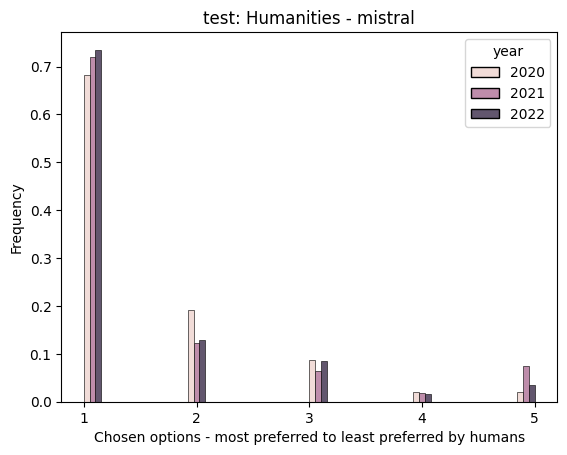

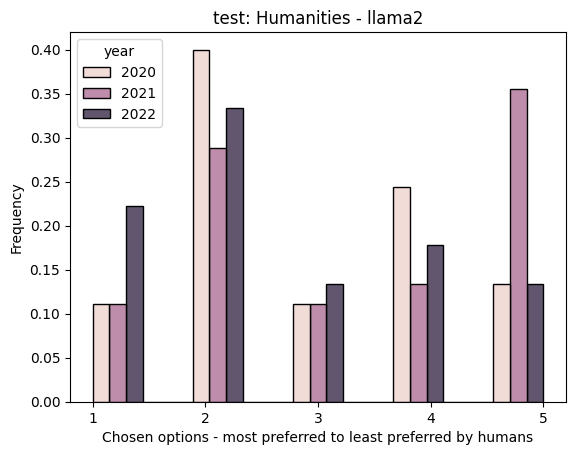

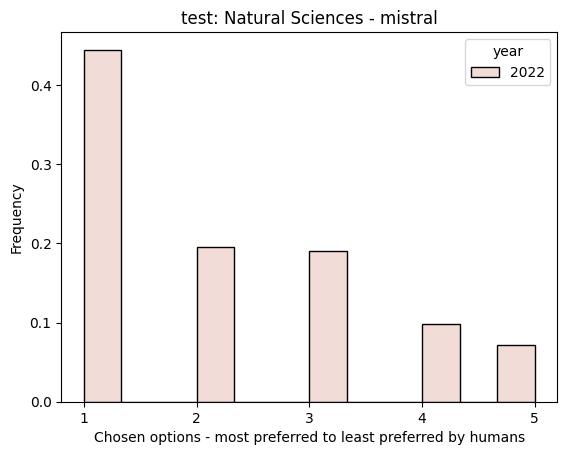

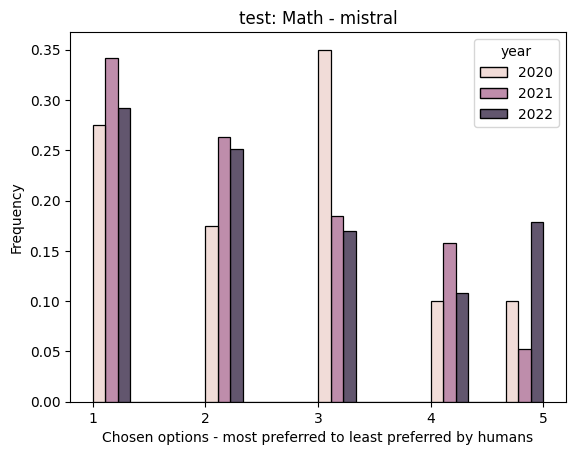

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

for exam in ['CH', 'CN', 'MT']:
    for llm in ['mistral', 'llama2']:

        if exam not in dic_logs[llm].keys() or len(dic_logs[llm][exam]) == 0:
            continue
        
        human_sequence_data = []
        year_data = []
        for year in dic_logs[llm][exam].keys():
                   sequence = dic_logs[llm][exam][year]['human_sequence'].tolist()

                   # We do not want to take guessed options into account.
                   if 'invalid_answer' in dic_logs[llm][exam][year].columns:
                       invalid = dic_logs[llm][exam][year]['invalid_answer'].tolist()
                       sequence = [num for num, invalid in zip(sequence, invalid) if invalid == False]
                         
                        
                   human_sequence_data += sequence
                   year_data += [year] * len(sequence)
            
        dfs = pd.DataFrame(data={'human_sequence': human_sequence_data, 
                             'year': year_data 
                        })

        sns.histplot(data=dfs, x="human_sequence", hue="year", stat="probability", common_norm=False, multiple="dodge"), #shrink=.8)
        
        plt.xlabel('Chosen options - most preferred to least preferred by humans')
        plt.ylabel('Frequency')
        plt.title(f'test: {dic_exam_to_paper_name[exam]} - {llm}')
        plt.xticks([1, 2, 3, 4, 5])
        plt.savefig(f'figures/distractor-analysis/{llm}-{exam}-humanity-histogram.pdf', format='pdf',bbox_inches='tight')
        plt.show()


Here we show the same data, but in a compressed form.
"Average Humanity" is the average choice LLMs make, 1st to 5h option.
For each option shuffling, we can compute the average humanity of the LLM for that particular shuffling, and hence we can display a boxplot.

In the boxplot,  1 means the LLM always choose the options human prefer.
Results show that LLM is very human in the Humanities test, less human in the Natural Sciences and even less in the Math.


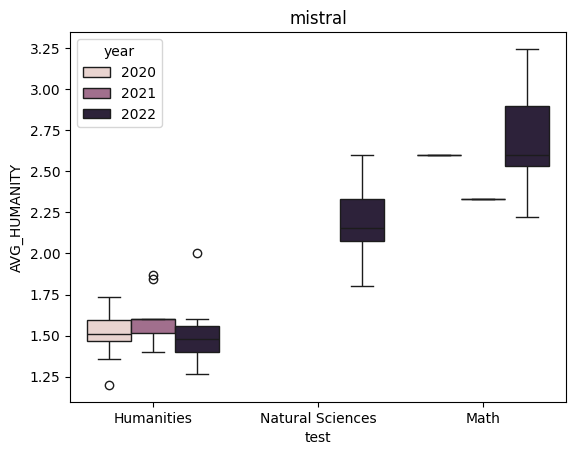

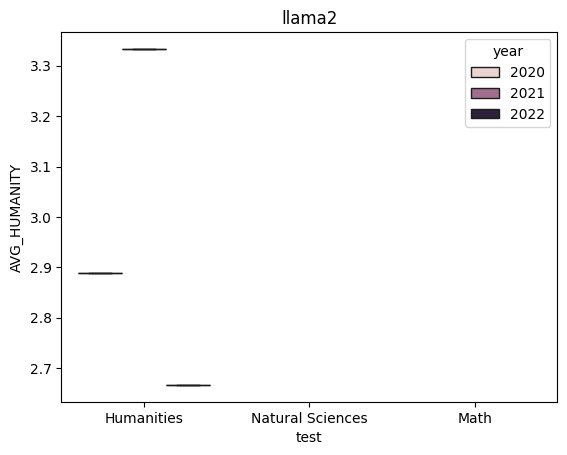

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

for llm in ['mistral', 'llama2']:
    dfs = []
    for exam in dic_test_responses[llm].keys():
        for year in dic_test_responses[llm][exam].keys():
            dic_test_responses[llm][exam][year]['test'] = dic_exam_to_paper_name[exam]
            dic_test_responses[llm][exam][year]['year'] = year
            dfs.append(dic_test_responses[llm][exam][year])
            
    df = pd.concat(dfs, ignore_index=True, axis=0)
    plt.title(f"{llm}")
    sns.boxplot(data=df, y="AVG_HUMANITY", x="test", hue="year", order=['Humanities', 'Natural Sciences', 'Math'])
    plt.savefig(f'figures/distractor-analysis/avg-{llm}-humanity.pdf', format='pdf',bbox_inches='tight')
    plt.show()




One distractor analysis costly to conduct with real students but that we can run with LLMs is to present differente subsets of the options in order to unveil consistency patterns.

Suppose I ask you, 'What is the capital of Massachusetts?' If you know the answer or know how to arrive at it, it should not affect much whether I present you with 2 options, 5 options, or 20 options. Hence, the rate at which LLMs change their choice as we present more options and make the test monotonically harder unveils the degree to which the LLM possesses 'true knowledge.'

To run fewer experiments, for each test and year, we conducted the following experiments: we presented the top two most popular options, then the top three, the top four, and only then the complete set of 5 options. The correct option is included as the first option regardless of its popularity. In a second experiment, we also present 2, 3, 4, and 5 options, but now we choose from the least chosen to the most chosen. For example, we expect this test to be easier for LLMs. Again, the correct option is always selected as the first option.

The behavior is very different depending on the test. For humanities, when presented with two options, accuracy is around 80% — note that a random guesser would on average score 50%. The interesting pattern is that as we present more options to the LLM, accuracy is kept roughly at the same level, meaning that the LLM is not distracted by wrong options.

For Natural Sciences, accuracy for two options starts at 73%, which is not that far from 80% for Humanities. However, as we present more options to the LLM, accuracy decreases and stops  when five options are presented.

In this graph we show only mistral in PT-BR. I think that when we plot several LLMs with different setups, some curves will reach the same score @ 5 options, but the curve shape will be different.ons




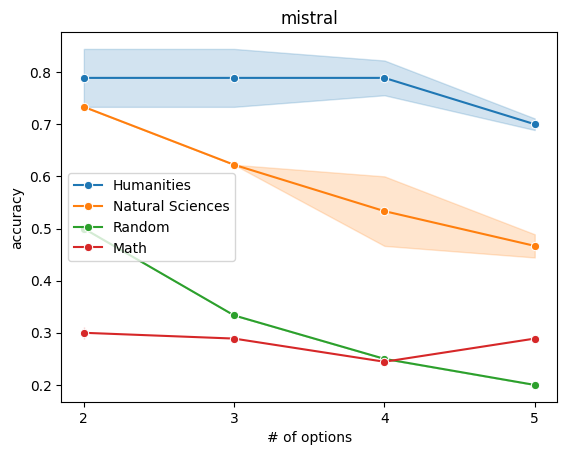

In [27]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

# TODO: guardar acuracia em test_responses, mais facil explicar no paper
# TODO: guardar "number_of_options" instead of VALID_OPTION_COUNT

llm = 'mistral'

ch_df = pd.read_csv("C:/Users/pedro/Downloads/TRI/test_responses_llms/SUBSET/CH/2022/test_responses.csv")
cn_df = pd.read_csv("C:/Users/pedro/Downloads/TRI/test_responses_llms/SUBSET/CN/2022/test_responses.csv")
mt_df = pd.read_csv("C:/Users/pedro/Downloads/TRI/test_responses_llms/SUBSET/MT/2022/test_responses.csv")


ch_df['accuracy'] = ch_df['CTT_SCORE'] / 45
cn_df['accuracy'] = cn_df['CTT_SCORE'] / 45
mt_df['accuracy'] = mt_df['CTT_SCORE'] / 45

ch_df['expected_accuracy'] = ch_df['EXPECTED_CTT_SCORE'] / 45
cn_df['expected_accuracy'] = cn_df['EXPECTED_CTT_SCORE'] / 45
mt_df['expected_accuracy'] = mt_df['EXPECTED_CTT_SCORE'] / 45

sns.lineplot(x=ch_df['VALID_OPTION_COUNT'], y=ch_df['accuracy'], label='Humanities', marker='o', errorbar='ci')
sns.lineplot(x=cn_df['VALID_OPTION_COUNT'], y=cn_df['accuracy'], label='Natural Sciences', marker='o', errorbar='ci')
#  BASELINE
sns.lineplot(x=cn_df['VALID_OPTION_COUNT'], y=cn_df['expected_accuracy'], label='Random', marker='o', errorbar='ci')
sns.lineplot(x=mt_df['VALID_OPTION_COUNT'], y=mt_df['accuracy'], label='Math', marker='o', errorbar='ci')



#plt.xticks([1, 2, 3, 4, 5])
plt.title('mistral')
plt.ylabel('accuracy')
plt.xlabel('# of options')
plt.xticks([2, 3, 4, 5])

plt.savefig(f'figures/distractor-analysis/subset-accuracy-{llm}.pdf', format='pdf',bbox_inches='tight')


Another distractor analysis we can conduct is to observe not only the rate at which the LLM change its mind
when presented with an (incorrect) option it has not seen before, but also if the change is consistent.

A consistent change happens when presented with an extra option, the LLM chooses it. For example, if when presented with AB the LLM chooses B,
it is a consistent change to chose C when presented with ABC. However, sometimes a LLM changes its mind and changes its choice to an option
it could have chosen already, for example, choosing B from AB but choosing A when presented with ABC. 

Again, mistral is quite consistent while doing the Humanities test: it keeps its original choice 85% of the time, and only 3% of the time it performs an inconsistent change. Again, Natural Sciences is between Humanities and Math.

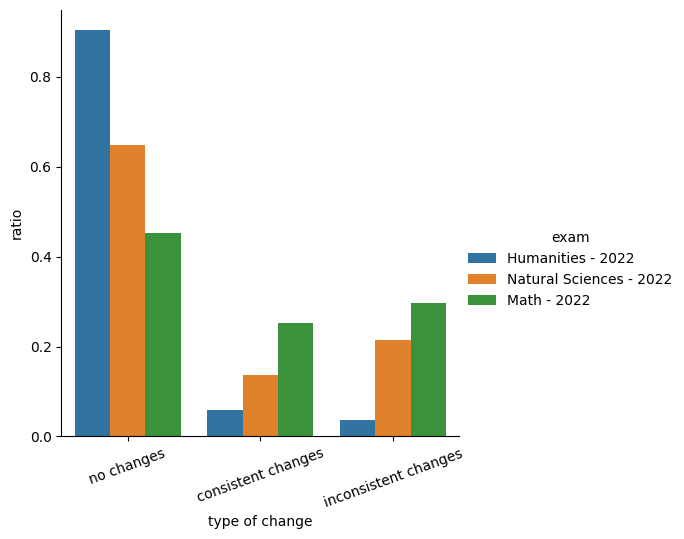

In [28]:
from collections import defaultdict
import pandas as pd
import seaborn as sns

ch_df = pd.read_csv("C:/Users/pedro/Downloads/TRI/test_responses_llms/SUBSET/CH/2022/subset_consistency.csv")
cn_df = pd.read_csv("C:/Users/pedro/Downloads/TRI/test_responses_llms/SUBSET/CN/2022/subset_consistency.csv")
mt_df = pd.read_csv("C:/Users/pedro/Downloads/TRI/test_responses_llms/SUBSET/MT/2022/subset_consistency.csv")

dic_subset_df = defaultdict(dict)

dic_subset_df['mistral']['CH'] = {}
dic_subset_df['mistral']['CN'] = {}
dic_subset_df['mistral']['MT'] = {}

dic_subset_df['mistral']['CH'][2022] = ch_df
dic_subset_df['mistral']['CN'][2022] = cn_df
dic_subset_df['mistral']['MT'][2022] = mt_df

categories = []
percentages = []
exams = []
for llm in ['mistral']:
    for exam in dic_subset_df[llm].keys():
        for year in dic_subset_df[llm][exam]:
            sum_df = dic_subset_df[llm][exam][year].sum()/dic_subset_df[llm][exam][year]['possible_changes'].sum()

            categories.extend(['no changes', 'consistent changes', 'inconsistent changes'])
            percentages.extend([sum_df['no_changes'], sum_df['consistent_changes'], sum_df['inconsistent_changes']])
            exams.extend([f"{dic_exam_to_paper_name[exam]} - {year}"] * 3)

                       
df = pd.DataFrame(data={'type of change': categories, 'ratio': percentages, 'exam': exams})
g= sns.catplot(data=df, x="type of change", y="ratio", hue="exam", kind="bar")
g.set_xticklabels(rotation=20)
plt.savefig(f'figures/distractor-analysis/subset-consistency-{llm}.pdf', format='pdf',bbox_inches='tight')

